### Correcciones

**Parte teórica:**



**1.   Explica el modelo de regresión logística para clasificación. ¿Cómo se determina el umbral de decisión?**

- Sirve para clasificar entre dos opciones (sí/no).

**2.   Explica la intuición de la máquina de soporte vectorial para clasificación. ¿Cómo se determina qué modelo es mejor? ¿Cuál es la mayor diferencia que tiene contra un modelo de regresión logística?**

- Busca la mejor línea que separe las clases con el mayor espacio entre ellas
- Es mejor que la regresión logística cuando los datos no se separan fácil
- Comparamos modelos viendo cuál tiene mejor accuracy o AUC

**3.   ¿Cuáles son los componentes principales en un MLP para clasificación? Dibuja un ejemplo y señaliza.**

- Entrada
- Capas de neuronas en medio
- Salida

- **Dibujo:** Entrada → ○ ○ → ○ ○ ○ → Salida

**4.   ¿Cuál es el procedimiento a seguir cuando los datos no son linealmente separables en una SVC?**

- Si los datos no se separan con línea recta, usamos un kernel (como RBF) para transformar los datos y separarlos mejor

**5.   Describe qué es un hiperparámetro. ¿Por qué es importante ajustarlos? Da dos ejemplos de hiperparámetros.**

- Es un valor que tú eliges antes de entrenar.Afecta cómo aprende el modelo
- **Ejemplos:** C, learning rate

**6.   Dibuja un diagrama de flujo para describir el proceso de optimización Bayesiana.**

```text
Tenemos una función objetivo desconocida
   ↓
Modelamos su comportamiento con un Proceso Gaussiano
   ↓
Realizamos una evaluación inicial para obtener puntos de partida
   ↓
Entrenamos el modelo (regresión bayesiana)
   ↓
Creamos una tabla con predicciones e intervalos de confianza
   ↓
Seleccionamos el siguiente punto a probar (según la función de adquisición)
   ↓
Evaluamos ese punto en la función real (caja negra)
   ↓
Actualizamos el modelo con la nueva información
   ↺
(Repetimos el ciclo hasta alcanzar el criterio de parada)

**7.   ¿Qué es la curva ROC y cómo se usa para evaluar el desempeño de un modelo?**

- Sirve para medir qué tan bien separa el modelo las clases
- El AUC (0–1) dice qué tan bien lo hace (1 es perfecto)

**8.   Describe un espacio de Hilbert.**

- Espacio matemático grande donde podemos modificar los datos para separarlos mejor (SVM lo usa)

**9.   ¿Qué significa que una función de costo sea convexa? ¿Qué beneficios hay de que un modelo tenga una función de costo convexa?**

- Tiene un único mínimo (como un tazón)
- Ayuda a encontrar la mejor solución más fácil

**10.  Piensa en los 3 modelos aprendidos en este parcial: ¿En qué situaciones usarías cada uno y por qué?**

- Regresión logística	-> Problema simple y quieres interpretar el resultado
- SVM	-> Datos difíciles de separar o pocos datos
- MLP	-> Datos grandes y complejos, buscas alta precisión



**Parte práctica:**

In [24]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

In [23]:
!pip install scikit-optimize

**Ejercicio 1**

### Optimización Bayesiana

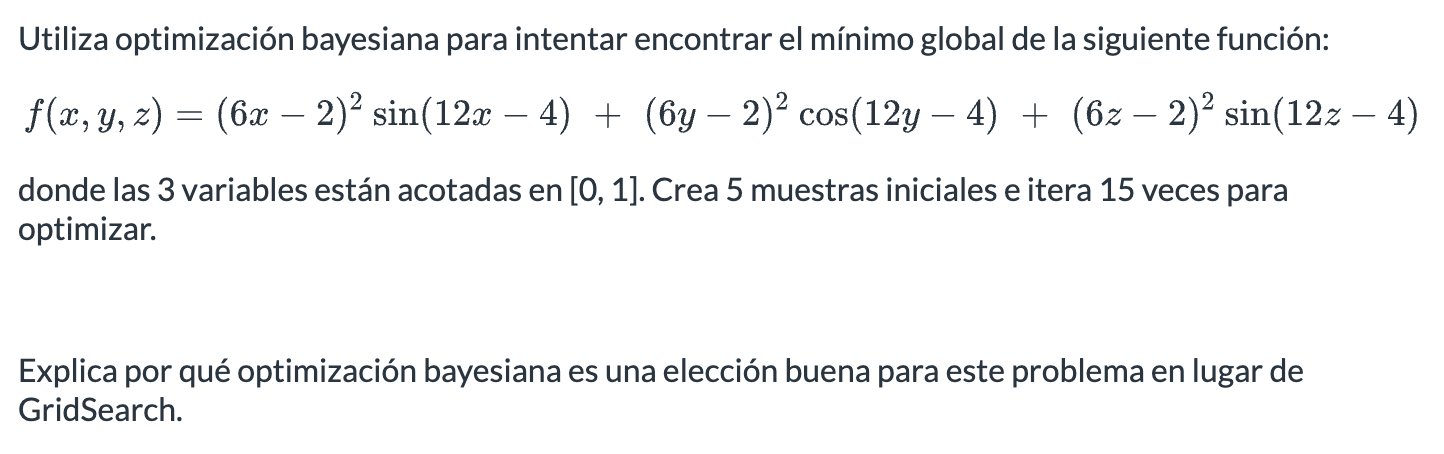

In [ ]:
from IPython.display import Image
Image('prob1.png',width=800, height=300)

In [25]:
# Función objetivo
def f(vars):
    x, y, z = vars
    return (6*x - 2)**2 * np.sin(12*x - 4) + \
           (6*y - 2)**2 * np.cos(12*y - 4) + \
           (6*z - 2)**2 * np.sin(12*z - 4)

# Límites de las variables
space = [
    Real(0, 1),  # x
    Real(0, 1),  # y
    Real(0, 1)   # z
]

# Optimización bayesiana
res = gp_minimize(
    f,
    space,
    n_calls=15,
    n_initial_points=5,
    random_state=42
)

In [26]:
print("x, y, z =", res.x)
print("f(x,y,z) =", res.fun)

x, y, z = [0.8028774055786997, 0.04035387681941707, 0.7477842014023145]
f(x,y,z) = -13.645438508027395


**Explicación:**

La optimización bayesiana es mejor que GridSearch porque aprende de cada intento, usa menos evaluaciones y encuentra el mínimo global más rápido, siendo ideal para funciones complejas como la del ejercicio.

**Ejercicio 2**

### Regresión Logística

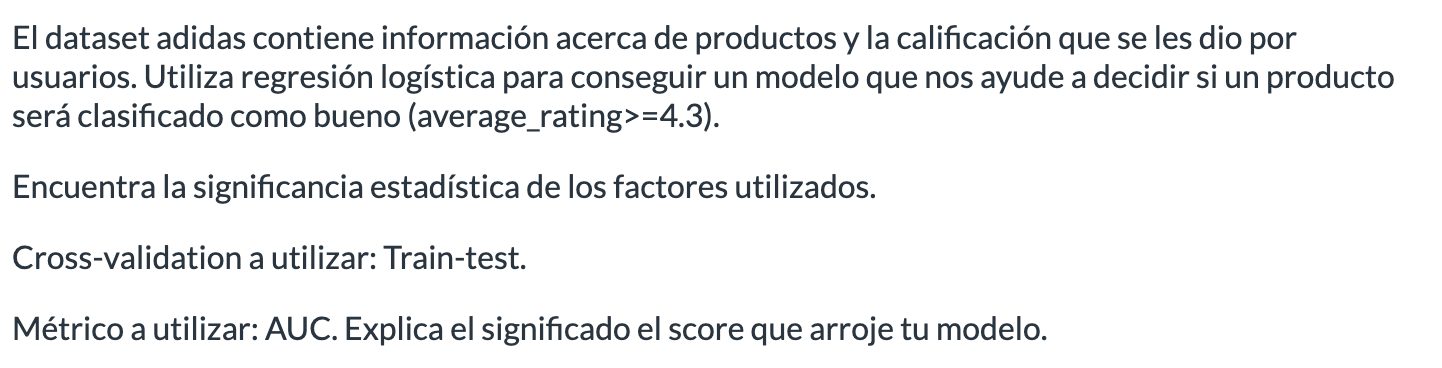

In [ ]:
from IPython.display import Image
Image('prob2.png',width=800, height=300)

In [27]:
df = pd.read_csv("adidas.csv")

cols_drop = [
    'url','name','sku','description','images',
    'source_website','source','breadcrumbs',
    'language','currency','color','crawled_at'
]
df.drop(columns=[c for c in cols_drop if c in df.columns], inplace=True, errors='ignore')

In [28]:
df

,selling_price,original_price,availability,category,brand,country,average_rating,reviews_count
0,40,NaN,InStock,Clothing,adidas,USA,4.5,35
1,150,NaN,InStock,Shoes,adidas,USA,4.8,4
2,70,NaN,InStock,Clothing,adidas,USA,4.9,42
3,160,NaN,InStock,Shoes,adidas,USA,3.7,7
4,65,NaN,InStock,Clothing,adidas,USA,4.7,11
...,...,...,...,...,...,...,...,...
840,72,$120,InStock,Shoes,adidas,USA,4.3,151
841,70,$100,InStock,Shoes,adidas,USA,4.7,135
842,35,$50,InStock,Shoes,adidas,USA,4.7,190
843,40,$50,InStock,Shoes,adidas,USA,4.7,190


In [29]:
#Limpieza
if df['original_price'].dtype == 'object':
    df['original_price'] = df['original_price'].str.replace('$', '', regex=False).astype(float)

In [30]:
# Target binario
df['target'] = (df['average_rating'] >= 4.3).astype(int)

In [31]:
num_cols = ['selling_price','original_price','reviews_count']
cat_cols = ['availability','category','brand','country']

df = df.dropna(subset=num_cols + cat_cols + ['target'])
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop(columns=['average_rating','target'])
y = df['target']

In [33]:
#División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [34]:
#Escalamos
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [35]:
#Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [36]:
#AUC
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred  = model.predict_proba(X_test)[:,1]

print(f"AUC (Train): {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"AUC (Test):  {roc_auc_score(y_test, y_test_pred):.4f}")

AUC (Train): 0.7251
AUC (Test):  0.6596


In [38]:
#Significancia estadística
n, p = X_train.shape
y_pred = model.predict_proba(X_train)[:,1]
resid = y_train - y_pred
RSS = np.sum(resid**2)
var_resid = RSS / (n - p - 1)

In [39]:
#Convertimos a float
X_design = np.column_stack((np.ones(n), X_train.to_numpy(dtype=float)))
X_design = X_design.astype(float)

In [40]:
#Matriz inversa
XtX_inv = np.linalg.inv(X_design.T @ X_design + np.eye(p+1) * 1e-6)

In [41]:
var_beta = np.diagonal(XtX_inv) * var_resid
std_beta = np.sqrt(var_beta)
betas = np.concatenate(([model.intercept_[0]], model.coef_.flatten()))
t_stats = betas / std_beta
p_vals = [2 * (1 - stats.t.cdf(abs(t), n - p - 1)) for t in t_stats]

In [44]:
print("Significancia estadística")
for i, (b, t, pval) in enumerate(zip(betas, t_stats, p_vals)):
    name = "Intercepto" if i == 0 else f"β{i}"
    sig = "Significativo" if pval < 0.05 else "No significativo"
    print(f"{name:10s} | β={b:8.4f} | t={t:8.4f} | p={pval:8.4e} | {sig}")

Significancia estadística 
Intercepto | β=  3.2134 | t= 70.6438 | p=0.0000e+00 | Significativo
β1         | β= -0.1519 | t= -2.3615 | p=1.8536e-02 | Significativo
β2         | β= -0.3308 | t= -5.0475 | p=6.0213e-07 | Significativo
β3         | β=  1.0612 | t= 76.8931 | p=0.0000e+00 | Significativo
β4         | β= -0.4418 | t= -1.9391 | p=5.2977e-02 | No significativo
β5         | β= -0.9012 | t=-18.7140 | p=0.0000e+00 | Significativo
β6         | β= -1.1192 | t=-21.1200 | p=0.0000e+00 | Significativo


**Explicación:**

Mi modelo tiene un AUC ≈ 0.66, lo que significa que tiene una precisión moderada para diferenciar entre productos con buena y mala calificación.

Es decir, el modelo acierta la mayoría de las veces al identificar cuáles productos son buenos, aunque aún puede mejorar.

**Ejercicio 3**

### Mejor Modelo

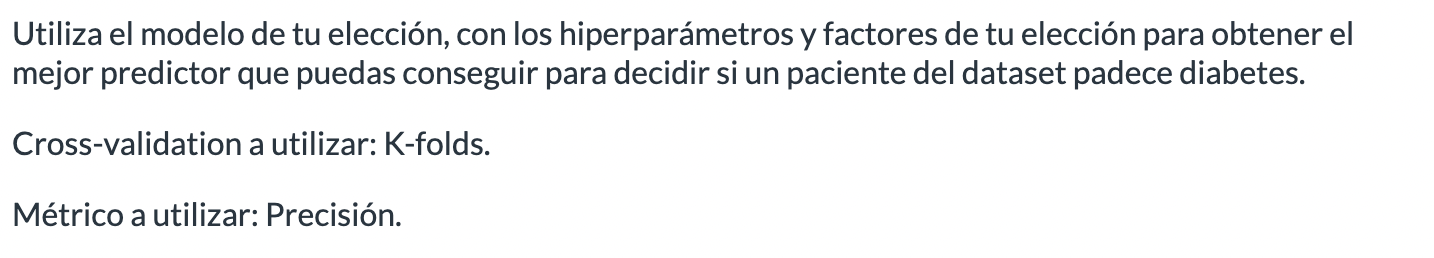

In [ ]:
from IPython.display import Image
Image('prob3.png',width=800, height=300)

In [ ]:
df = pd.read_csv("diabetes.csv")

y = df["Outcome"]
X = df.drop(columns=["Outcome"])

models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "SVC Linear": SVC(kernel="linear"),
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
scorer = make_scorer(precision_score)

results = {}
for name, model in models.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    score = cross_val_score(pipe, X, y, cv=kf, scoring=scorer).mean()
    results[name] = score

print("Resultados de precisión:")
for m,s in results.items():
    print(f"{m}: {s:.4f}")

Resultados de precisión:
LogReg: 0.7308
SVC Linear: 0.7297
